In [1]:
# camera calibration
from os import listdir
from scipy import misc
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

CAM_CAL_PATH = './camera_cal/'

cam_cal_imgs = []
for img_file in listdir(CAM_CAL_PATH):
    try:
        img = misc.imread(CAM_CAL_PATH + img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        cam_cal_imgs.append(img)
    except IOError: pass

17 found.


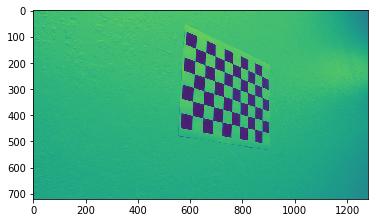

In [2]:
objp = np.zeros((6 * 9, 3), np.float32)
objp[:,:2] = np.mgrid[0:6, 0:9].T.reshape(-1,2)

object_points = []
img_points = []
for img in cam_cal_imgs:
    plt.imshow(img)
    ret, corners = cv2.findChessboardCorners(img, (9, 6), None)
    if (ret):
        object_points.append(objp)
        img_points.append(corners)

print (len(img_points), 'found.')

In [6]:
img_size = (cam_cal_imgs[1].shape[1], cam_cal_imgs[1].shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, img_points, img_size,None,None)

In [8]:
print (mtx, dist)

[[ 143.08147127    0.          639.4956478 ]
 [   0.          817.84727475  359.49932344]
 [   0.            0.            1.        ]] [[ -1.08929527e-02   3.00019798e-05  -4.85444918e-05   1.57584130e-03
   -2.35174525e-08]]


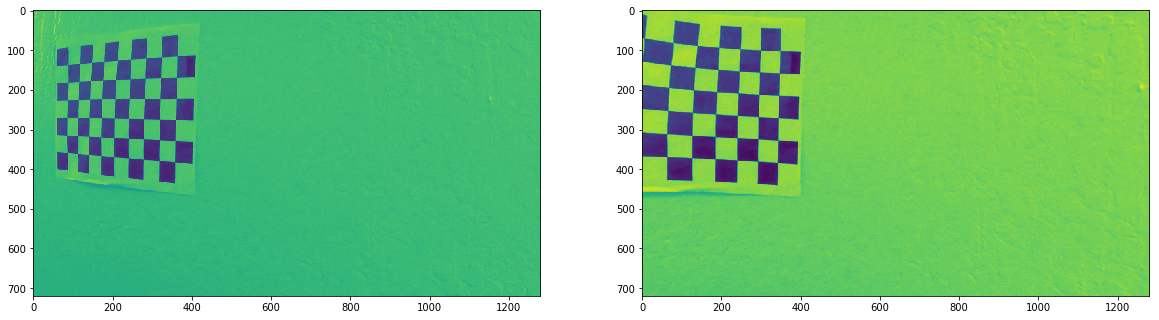

In [16]:
undist_test = cv2.undistort(cam_cal_imgs[10], mtx, dist, None, mtx)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(cam_cal_imgs[10])
plt.subplot(1,2,2)
plt.imshow(undist_test)
